# Análisis predictivo COVID-19
## Entrega Final - Analítica predictiva
## Universidad Nacional de Colombia
**Andres Cadavid, Gabriela Chamorro y Jose Luis Cossio**

## Conclusiones del análisis - Problema real 
### **Definición del problema real:**
Desde el 31 de diciembre de 2019, cuando se presenta el primer reporte de COVID-19 en China, se genera una alerta a nivel mundial por el temor a la propagación del virus, el 7 de marzo de 2020 se reporta en Colombia el primer caso confirmado de COVID-19 y el 10 de marzo del mismo año se detecta un caso en Medellín y en Buga. 

Puesto que el virus ha desencadenado una crisis económica y social en el país, se requiere estudiar a fondo las consecuencias de cada decisión tomada por parte del gobierno, las empresas, las familias y las personas en un ambiente de alta incertidumbre.

### **Definición del problema de analítica:**
En Colombia para agosto de 2020 se tiene un acumulado de más de 477.000 contagiados y más de 15.000 muertos a causa del COVID-19 a inicios de agosto de 2020. Las ciudades principales que, por población, son Bogotá, Medellín, Cali, Barranquilla y Cartagena presentan la mayor cantidad de casos confirmados y requieren tener una hoja de ruta que les permita tomar las mejores decisiones para garantizar el bienestar de los habitantes. Esta hoja de ruta consiste en procesar los datos disponibles por ciudad para los casos de COVID-19 y lograr realizar un pronóstico confiable del comportamiento de la pandemia en el corto y mediano plazo.

### Fuente de datos
https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data

### Metodología
CRISP-DM

### Desarrollo de los modelos
El equipo realizó un análisis exploratorio de los modelos diseñados para explicar el comportamiento de pandemias. En la literatura se encontraron tres corrientes, la primera sugiere estudiarlo como una serie de tiempo, la segunda, como un modelo poblacional de entradas y salidas y la tercera como un modelo de redes neuronales.En este sentido se decidió trabajar con:
- **SIR** (susceptibles, infectados y recuperados): corriente de fenómeno poblacional.
- **LR MLP** (regresión lineal con perceptrones multicapa): corriente de derivados de modelos con nodos.
- **ARIMA** (modelo autorregresivo de medias móviles): corriente de series de tiempo.

Para el modelo SIR se ajustaron los parámetros de la simulación, para que se adecuen a la realidad colombiana y de la naturaliza de propagación del COVID-19 en particular. Tomando como referencia la explicación matemática de Tom Rocks Maths - Oxford y Jonathan Soma.

Para los modelos LR MLP y ARIMA se utilizó información pública dispuesta por datos.gov.co por medio del uso de SODA API para la extracción automática de la  información, luego se realizó un análisis descriptivo de la información en la que se encontró que cada registro era información categórica por caso, por lo que se recurrió a una transformación de lo datos para obtener cantidades por día, se realizó la prueba de raíz unitaria de Dickey-Fuller para determinar si la serie contaba con las características adecuadas para ser modelada con la aproximación de series de tiempo, sin embargo, se encontró necesario realizar una transformación adicional y trabajar con la tasa de crecimiento diario para los casos nuevos, recuperados y fallecidos.

En el caso del LR MLP se optó por modelar los datos transformados a tasas diarias y se seleccionaron los parametros de matriz de Hessian, tasa de aprendizaje e iteraciones propuestos para datos de series de tiempo.

El modelo ARIMA cuenta con tres parámetros que determinan su comportamiento autorregresivo, de diferenciación y de medias móviles (p,d,q) respectivamente, los cuales fueron optimizados con una malla definida de valores posibles, buscando minimizar el error cuadrático medio (MSE). Para esto se apoyo en el paquete statsmodels.tsa.arima_model.Se entrenó el modelo para Colombia y las cinco ciudades principales con los parámetros previamente seleccionados.

### Conclusiones

- En los datos observados se percibe que la pandemia en sus tres factores esta superando un pico de contagio.

- Mediante la simulación SIR no se recogen políticas publicas para disminuir la propagación de la enfermedad y por esto es posible atribuir a la cuarentena que el pico se lograra retrasar 25 días.

- En ARIMA para la mayor parte del periodo analizado las tasas de crecimiento son positivas, esto sucede porque la información disponible de la pandemia es la de un ciclo de propagación, los datos observados de contracción no son lo suficientemente significativos para reconocer un cambio de tendencia.

### Trabajos futuros

- Se sugiere trabajar con un modelo no lineal que permita reconocer el comportamiento natural de una pandemia (propagación, contracción, rebrote). Puesto que los modelos de serie de tiempo tradicionales (ARIMA), dependen en gran medida de la historia observada

- Para un modelo de redes neuronales (o sus derivados), se sugiere diversificar el set de entrenamiento, de tal forma que el modelo no se entrene para una sola etapa del fenómeno.

- Es valioso para la modelación combinar el conocimiento del fenómeno real con las habilidades analíticas, es valido que si existe un comportamiento esperado del fenómeno el modelo busque explicar y validar dicho comportamiento.

- Si bien un modelo explica el comportamiento de un hecho, no es suficiente para tomar una decision, también es importante contar con un criterio experto antes de tomar decisiones con los resultados.

### Importar paquetes requeridos

In [1]:
import requests
import pandas as pd
from datetime import date
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Extracción de datos

In [2]:
def extract_data(api_url, limit):
    # Funcion para la extraccion de los datos via SODA API ODATA
    data_len = 50000
    offset = 0
    appended_data = []
    while data_len >= limit:
        time.sleep(1)
        params = {'$limit': limit, '$offset': offset}
        response = requests.get(api_url, params=params)
        data = response.json()
        data_len = len(data)
        if 'error' not in data or len(data) > 0:
            df = pd.DataFrame.from_dict(data, orient='columns')
            df['extracted_at_utc'] = pd.to_datetime('now', utc=True)
            appended_data.append(df)
            offset = offset + limit
    return pd.concat(appended_data, ignore_index=True, sort=False)

### Transformación de datos

In [3]:
def data_transform(df, start_date):
    # Funcion transformacion de los datos (Data quality)
    df_in = df
    if 'atenci_n' in df.columns:
        df_in['atenci_n'] = df['atenci_n'].str.strip()
        df_in['atenci_n'] = df['atenci_n'].str.lower()
    delta = date.today() - start_date
    df_dates = pd.DataFrame(pd.date_range(start_date, periods=delta.days, freq='D'), columns=['fecha'])
    df_in['fecha_de_notificaci_n'] = pd.to_datetime(df_in['fecha_de_notificaci_n'])
    df_in['fecha_de_muerte'] = pd.to_datetime(df_in['fecha_de_muerte'])
    df_in['fecha_recuperado'] = pd.to_datetime(df_in['fecha_recuperado'])
    df_in['fecha_diagnostico'] = pd.to_datetime(df_in['fecha_diagnostico'])
    return df_in, df_dates


def data_agg_col(df, df_dates, city_filter):
    # Funcion para realizar agregaciones
    if city_filter is None:
        df_filtered = df
    else:
        df_filtered = df.loc[df['ciudad_de_ubicaci_n'].isin(city_filter)]
    df_filtered['c_recuperado'] = df_filtered['atenci_n'].apply(lambda x : 1 if x == 'recuperado' else 0)
    df_filtered['c_fallecido'] = df_filtered['atenci_n'].apply(lambda x: 1 if x == 'fallecido' else 0)
    df_filtered['c_caso'] = 1
    df_casos = df_filtered.groupby(['fecha_diagnostico'], as_index=False)['c_caso'].sum()
    df_casos = df_casos.rename(columns={'fecha_diagnostico': 'fecha'})
    df_muertes = df_filtered.groupby(['fecha_de_muerte'], as_index=False)['c_fallecido'].sum()
    df_muertes = df_muertes.rename(columns={'fecha_de_muerte':'fecha'})
    df_recuperados = df_filtered.groupby(['fecha_recuperado'], as_index=False)['c_recuperado'].sum()
    df_recuperados = df_recuperados.rename(columns={'fecha_recuperado': 'fecha'})
    df_full = pd.merge(df_dates, df_casos, how='left', on=['fecha'])
    df_full = pd.merge(df_full, df_muertes, how='left', on=['fecha'])
    df_full = pd.merge(df_full, df_recuperados, how='left', on=['fecha'])
    return df_full

## ARIMA

### Evaluación del modelo ARIMA para obtener el mejor (p,d,q)

In [4]:
def evaluate_arima_model(X, arima_order, train_perc):
    # prepare training dataset
    train_size = int(len(X) * train_perc)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(arima_order))
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

### Evaluación de la combinación de valores de p, d y q para el modelo ARIMA

In [5]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order, 0.8)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [6]:
def data_prep_normalize(df_o):
    df = df_o.copy()
    df['casos_lag'] = df['c_caso'].shift(1)
    df['fallecidos_lag'] = df['c_fallecido'].shift(1)
    df['recuperados_lag'] = df['c_recuperado'].shift(1)
    df = df.replace({0: np.nan})
    df['casos_diff'] = (df['c_caso'] - df['casos_lag'])/df['casos_lag']
    df['fallecidos_diff'] = (df['c_fallecido'] - df['fallecidos_lag']) / df['fallecidos_lag']
    df['recuperados_diff'] = (df['c_recuperado'] - df['recuperados_lag']) / df['recuperados_lag']
    df['tasa_casos'] = df['casos_lag']/df['c_caso']
    df['tasa_fallecitos'] = df['fallecidos_lag']/df['c_fallecido']
    df['tasa_recuperados'] = df['recuperados_lag']/ df['c_recuperado']

    # Eliminacion de Outliers
    quant_95_casos = df['casos_diff'].quantile(.95)
    mean_casos = df['casos_diff'].mean()

    quant_95_fallecidos = df['fallecidos_diff'].quantile(.95)
    mean_fallecidos = df['fallecidos_diff'].mean()

    quant_95_recuperados = df['recuperados_diff'].quantile(.95)
    mean_recuperados = df['recuperados_diff'].mean()

    df['casos_diff'] = df['casos_diff'].apply(lambda x: x if x <= quant_95_casos else mean_casos)
    df['fallecidos_diff'] = df['fallecidos_diff'].apply(lambda x: x if x <= quant_95_fallecidos else mean_fallecidos)
    df['recuperados_diff'] = df['recuperados_diff'].apply(lambda x: x if x <= quant_95_recuperados else mean_recuperados)

    df = df.fillna(0)
    # Eliminacion de outliers ultimas fechas por datos faltantes desde la fuente
    df.drop(df.tail(2).index, inplace=True)
    return df

In [7]:
def arima_model_imp(df, train_perc, pred_range, ranges_casos, ranges_recu, ranges_fall):
    df_entrenamiento = df[['fecha', 'casos_diff']].iloc[:int(round((len(df) * train_perc) - 1, 0))]
    df_entrenamiento_recu = df[['fecha', 'recuperados_diff']].iloc[:int(round((len(df) * train_perc) - 1, 0))]
    df_entrenamiento_fall = df[['fecha', 'fallecidos_diff']].iloc[:int(round((len(df) * train_perc) - 1, 0))]
    serie_entrenamienti = df_entrenamiento.set_index('fecha')
    serie_entrenamienti_recu = df_entrenamiento_recu.set_index('fecha')
    serie_entrenamienti_fall = df_entrenamiento_fall.set_index('fecha')

    model_casos = ARIMA(serie_entrenamienti['casos_diff'], order=(ranges_casos))
    model_fit_casos = model_casos.fit(disp=0)
    model_recu = ARIMA(serie_entrenamienti_recu['recuperados_diff'], order=(ranges_recu))
    model_fit_recu = model_recu.fit(disp=0)
    model_fall = ARIMA(serie_entrenamienti_fall['fallecidos_diff'], order=(ranges_fall))
    model_fit_fall = model_fall.fit(disp=0)
    # Pronosticos corto plazo
    yhat_corto_casos = model_fit_casos.forecast(steps=pred_range[0])[0]
    yhat_corto_recuperados = model_fit_recu.forecast(steps=pred_range[0])[0]
    yhat_corto_fallecidos = model_fit_fall.forecast(steps=pred_range[0])[0]
    # Pronosticos largo plazo
    yhat_largo_casos = model_fit_casos.forecast(steps=pred_range[1])[0]
    yhat_largo_recuperados = model_fit_recu.forecast(steps=pred_range[1])[0]
    yhat_largo_fallecidos = model_fit_fall.forecast(steps=pred_range[1])[0]
    response = [
        {'pronostico_corto_casos': yhat_corto_casos,
         'pronostico_largo_casos': yhat_largo_casos},
        {'pronostico_corto_recuperados': yhat_corto_recuperados,
         'pronostico_largo_recuperados': yhat_largo_recuperados},
        {'pronostico_corto_fallecidos': yhat_corto_fallecidos,
         'pronostico_largo_fallecidos': yhat_largo_fallecidos},
                ]
    return response

In [8]:
def error_calculation(df, train_perc,range_c, range_rec, range_fall):
    serie_casos = df.set_index('fecha')
    serie_recuperados = df.set_index('fecha')
    serie_fallecidos = df.set_index('fecha')
    error_casos = evaluate_arima_model(serie_casos['casos_diff'], range_c, train_perc)
    error_recu = evaluate_arima_model(serie_recuperados['recuperados_diff'], range_rec, train_perc)
    error_fall = evaluate_arima_model(serie_fallecidos['fallecidos_diff'], range_fall, train_perc)
    response = [
        {'error_casos': error_casos},
        {'error_recuperados': error_recu},
        {'error_fallecidos': error_fall}

    ]
    return response

In [9]:
def translate_prediction(last_value_base, y_pred):
    temp_val = last_value_base
    trans_values = []
    for val in y_pred:
        new_t_val = temp_val*(1 + val)
        trans_values.append(new_t_val)
        temp_val = new_t_val
    return trans_values

In [10]:
api_url = "https://www.datos.gov.co/resource/gt2j-8ykr.json"
df_casos = extract_data(api_url, 50000)
df_casos, df_dates = data_transform(df_casos,date(2020,3,1))

In [11]:
df_full = data_agg_col(df_casos, df_dates, None)
df_full_medellin = data_agg_col(df_casos, df_dates, ['Medellín'])
df_full_bogota = data_agg_col(df_casos, df_dates, ['Bogotá D.C.'])
df_full_cartagena = data_agg_col(df_casos, df_dates, ['Cartagena de Indias'])
df_full_cali = data_agg_col(df_casos, df_dates, ['Cali'])
df_full_barranquilla = data_agg_col(df_casos, df_dates, ['Barranquilla'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

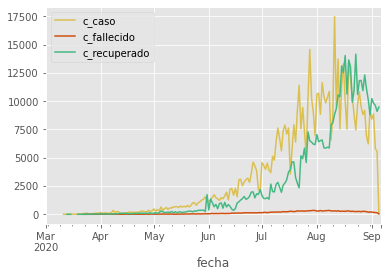

In [12]:
plt.style.use('ggplot')
df_full.plot(x='fecha',
        y=['c_caso', 'c_fallecido', 'c_recuperado'],
        color=['#dbc050', '#d04f0e', '#45b983'],
        kind='line')

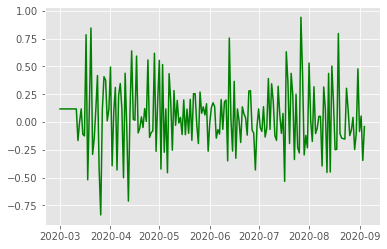

In [13]:
df_norm_col = data_prep_normalize(df_full)
df_norm_medellin = data_prep_normalize(df_full_medellin)
df_norm_bogota = data_prep_normalize(df_full_bogota)
df_norm_cartagena = data_prep_normalize(df_full_cartagena)
df_norm_cali = data_prep_normalize(df_full_cali)
df_norm_barranquilla = data_prep_normalize(df_full_barranquilla)
# Visualizar la distribucion de los datos graficamente posterior a la normalizacion
plt.plot(df_norm_col['fecha'],df_norm_col['casos_diff'], '-g')

Text(0.5, 0, 'Fecha')

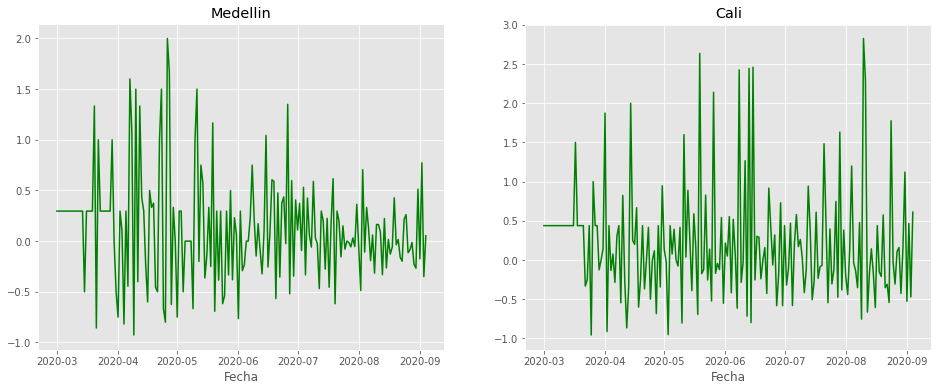

In [14]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2 , 1)
plt.plot(df_norm_medellin['fecha'],df_norm_medellin['casos_diff'], '-g')
plt.title('Medellin')
plt.xlabel('Fecha')
plt.subplot(1, 2 , 2)
plt.plot(df_norm_cali['fecha'],df_norm_cali['casos_diff'], '-g')
plt.title('Cali')
plt.xlabel('Fecha')

Text(0.5, 0, 'Fecha')

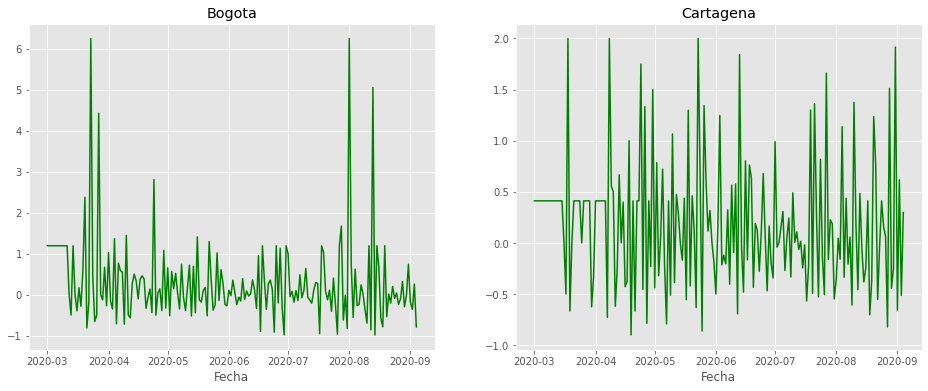

In [15]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2 , 1)
plt.plot(df_norm_bogota['fecha'],df_norm_bogota['casos_diff'], '-g')
plt.title('Bogota')
plt.xlabel('Fecha')
plt.subplot(1, 2 , 2)
plt.plot(df_norm_cartagena['fecha'],df_norm_cartagena['casos_diff'], '-g')
plt.title('Cartagena')
plt.xlabel('Fecha')

In [16]:
df_full.describe()

,c_caso,c_fallecido,c_recuperado
count,181.000000,169.000000,175.000000
mean,3615.883978,125.183432,2901.542857
std,4114.501462,114.949298,3965.982444
min,1.000000,1.000000,1.000000
25%,236.000000,18.000000,101.000000
50%,1472.000000,80.000000,880.000000
75%,6924.000000,245.000000,4784.000000
max,17466.000000,352.000000,14151.000000


In [17]:
df_norm_col.describe()

,c_caso,c_fallecido,c_recuperado,casos_lag,fallecidos_lag,recuperados_lag,casos_diff,fallecidos_diff,recuperados_diff,tasa_casos,tasa_fallecitos,tasa_recuperados
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,3480.872340,112.351064,2650.500000,3451.255319,111.601064,2602.095745,0.049166,0.029085,0.051658,0.984063,0.919913,0.918036
std,4095.024928,115.485185,3869.282919,4099.981294,115.755668,3845.012832,0.294279,0.222277,0.249201,0.581085,0.577262,0.482545
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.836066,-0.800000,-0.777906,0.000000,0.000000,0.000000
25%,183.500000,11.000000,78.500000,180.000000,10.750000,76.000000,-0.121886,-0.062946,-0.087935,0.740141,0.797917,0.765457
50%,1314.000000,57.500000,477.000000,1279.500000,53.500000,421.500000,0.048451,0.053116,0.069014,0.953793,0.949568,0.935442
75%,6751.750000,222.500000,3782.500000,6751.750000,222.500000,3375.500000,0.195717,0.101573,0.137515,1.138804,1.067176,1.096415
max,17466.000000,352.000000,14151.000000,17466.000000,352.000000,14151.000000,0.943249,0.666667,0.895372,6.100000,5.000000,4.502591


## Entrenamiendo del modelo y selección de los mejores parametros p, d y q para casos, recuperados y fallecidos

In [18]:
p = [0,1,3]
d = [0,1]
q = [0,1,3]
#df_entrenamiento = df_norm_cali[['fecha', 'fallecidos_diff']].iloc[:int(round((len(df_norm_medellin) * 0.8) - 1, 0))]
test = df_norm_col.set_index('fecha')
evaluate_models(test['casos_diff'], p, d, q)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0) MSE=0.086
ARIMA(0, 0, 1) MSE=0.066
ARIMA(0, 0, 3) MSE=0.068


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0) MSE=0.238


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels

ARIMA(0, 1, 1) MSE=0.086
ARIMA(1, 0, 0) MSE=0.076
ARIMA(1, 0, 1) MSE=0.068
ARIMA(1, 0, 3) MSE=0.070


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0) MSE=0.176


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3) MSE=0.064
ARIMA(3, 0, 0) MSE=0.070


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1) MSE=0.074


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianI

ARIMA(3, 0, 3) MSE=0.076
ARIMA(3, 1, 0) MSE=0.120


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1) MSE=0.067


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Best ARIMA(1, 1, 3) MSE=0.064


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


In [19]:
response_col = arima_model_imp(df_norm_col, 0.8, [7, 15], [4, 0, 0], [3, 1, 0], [1, 1, 3])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [20]:
response_med = arima_model_imp(df_norm_medellin, 0.8, [7, 15], [1, 1, 3], [1, 1, 1], [3, 1, 1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/

In [21]:
response_bog = arima_model_imp(df_norm_bogota, 0.8, [7, 15], [0, 0, 1], [0, 0, 0], [3, 1, 1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [22]:
response_cal = arima_model_imp(df_norm_cali, 0.8, [7, 15], [0, 0, 0], [1, 1, 1], [3, 1, 1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/

In [23]:
response_car = arima_model_imp(df_norm_cartagena, 0.8, [7, 15], [1, 1, 3], [1, 1, 3], [1, 0, 1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [24]:
response_bar = arima_model_imp(df_norm_barranquilla, 0.8, [7, 15], [4, 0, 0], [1, 1, 3], [0, 0, 1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


### Traducción de problema analítico a problema real

In [25]:
last_real_val_casos_col = df_norm_col.tail(1)['c_caso'].values[0]
last_real_val_rec_col = df_norm_col.tail(1)['c_recuperado'].values[0]
last_real_val_fall_col = df_norm_col.tail(1)['c_fallecido'].values[0]

In [26]:
last_real_val_casos_med = df_norm_medellin.tail(1)['c_caso'].values[0]
last_real_val_rec_med = df_norm_medellin.tail(1)['c_recuperado'].values[0]
last_real_val_fall_med = df_norm_medellin.tail(1)['c_fallecido'].values[0]

In [27]:
last_real_val_casos_bog = df_norm_bogota.tail(1)['c_caso'].values[0]
last_real_val_rec_bog = df_norm_bogota.tail(1)['c_recuperado'].values[0]
last_real_val_fall_bog = df_norm_bogota.tail(1)['c_fallecido'].values[0]

In [28]:
last_real_val_casos_cali = df_norm_cali.tail(1)['c_caso'].values[0]
last_real_val_rec_cali = df_norm_cali.tail(1)['c_recuperado'].values[0]
last_real_val_fall_cali = df_norm_cali.tail(1)['c_fallecido'].values[0]

In [29]:
last_real_val_casos_car = df_norm_cartagena.tail(1)['c_caso'].values[0]
last_real_val_rec_car = df_norm_cartagena.tail(1)['c_recuperado'].values[0]
last_real_val_fall_car = df_norm_cartagena.tail(1)['c_fallecido'].values[0]

In [30]:
last_real_val_casos_bar = df_norm_barranquilla.tail(1)['c_caso'].values[0]
last_real_val_rec_bar = df_norm_barranquilla.tail(1)['c_recuperado'].values[0]
last_real_val_fall_bar = df_norm_barranquilla.tail(1)['c_fallecido'].values[0]

In [31]:
response_med[0]['corto_plazo_translate'] = translate_prediction(last_real_val_casos_col, response_med[0]['pronostico_corto_casos'])
response_med[1]['corto_plazo_translate'] = translate_prediction(last_real_val_rec_col, response_med[1]['pronostico_corto_recuperados'])
response_med[2]['corto_plazo_translate'] = translate_prediction(last_real_val_fall_col, response_med[2]['pronostico_corto_fallecidos'])

response_med[0]['largo_plazo_translate'] = translate_prediction(last_real_val_casos_col, response_med[0]['pronostico_largo_casos'])
response_med[1]['largo_plazo_translate'] = translate_prediction(last_real_val_rec_col, response_med[1]['pronostico_largo_recuperados'])
response_med[2]['largo_plazo_translate'] = translate_prediction(last_real_val_fall_col, response_med[2]['pronostico_largo_fallecidos'])


### Despliegue de los resultados - Resultado casos ARIMA a 15 dias 

In [32]:
df_full.drop(df_full.tail(2).index, inplace=True)

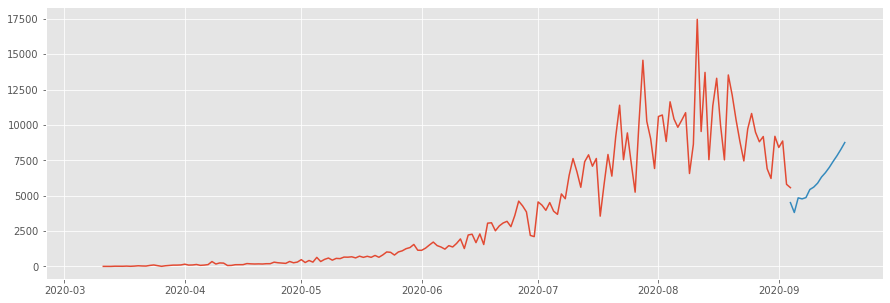

In [33]:
real_series = pd.Series(df_full['c_caso'].values, index=df_full['fecha'])
plt.figure(figsize=(15, 5))
plt.plot(real_series)

n_periods = 15
index_of_fc = pd.date_range(real_series.index[-1], periods = n_periods, freq='D')
fitted_series = pd.Series(translate_prediction(last_real_val_casos_col, response_col[0]['pronostico_largo_casos']), index=index_of_fc)
plt.plot(fitted_series)

### Resultado Recuperados ARIMA a 15 dias

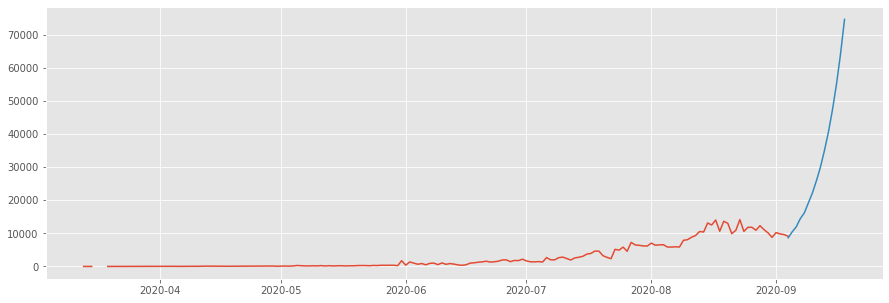

In [34]:
real_series = pd.Series(df_full['c_recuperado'].values, index=df_full['fecha'])
plt.figure(figsize=(15, 5))
plt.plot(real_series)

n_periods = 15
index_of_fc = pd.date_range(real_series.index[-1], periods = n_periods, freq='D')
fitted_series = pd.Series(translate_prediction(last_real_val_rec_col, response_col[1]['pronostico_largo_recuperados']), index=index_of_fc)
plt.plot(fitted_series)

### Resultado Fallecidos ARIMA a 15 dias

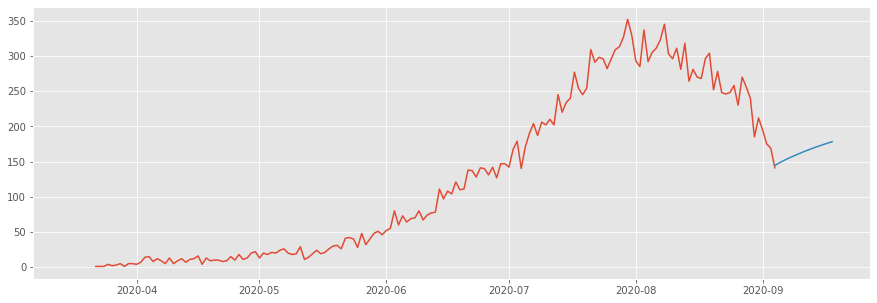

In [35]:
real_series = pd.Series(df_full['c_fallecido'].values, index=df_full['fecha'])
plt.figure(figsize=(15, 5))
plt.plot(real_series)

n_periods = 15
index_of_fc = pd.date_range(real_series.index[-1], periods = n_periods, freq='D')
fitted_series = pd.Series(translate_prediction(last_real_val_fall_col, response_col[2]['pronostico_largo_fallecidos']), index=index_of_fc)
plt.plot(fitted_series)

In [36]:
#df_full['fecha'].max()
response_car
translate_prediction(last_real_val_casos_bog, response_bog[0]['pronostico_corto_casos'])

[568.9149065008603,
 738.0072257889292,
 957.3569950321698,
 1241.9016832216698,
 1611.0184589365124,
 2089.843753413224,
 2710.985022830447]

In [37]:
pronostico_corto_casos = translate_prediction(last_real_val_casos_col, response_med[0]['pronostico_corto_casos'])

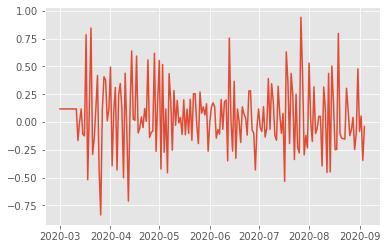

In [39]:
plt.plot(df_norm_col['fecha'],df_norm_col['casos_diff'])

## LR+MLP

In [40]:
df_filtrado = df_norm_col[['fecha', 'casos_diff']]
x = np.array(df_filtrado.index)
y = np.array(df_filtrado['casos_diff'])

In [41]:
%clear
import tensorflow as tf
import numpy as np
##
## Parametros
##
H = 3
learning_rate=0.01
max_iter=1000

In [42]:
##
## Datos
##
X = [[u] for u in x]
N = len(X[0])
P = len(X)

X_ = tf.constant(X, dtype=np.float32)
d_ = tf.constant(y, dtype=np.float32, shape=[len(y), 1])

var = tf.Variable(d_)
y_ = tf.constant(y, dtype=np.float32)
w = tf.Variable(y_)

In [43]:
##
## Info pronostico
##
Xpred = np.linspace(np.min(x), np.max(x), 15, dtype=np.float32)
Xpred = [[u] for u in Xpred]
Xpred_ = tf.constant(Xpred)

In [44]:
##
## Parámetros
##
intercept = tf.Variable(0.1 * np.mean(y),            dtype=np.float32)
WHOparams = tf.Variable(0.1 * np.random.randn(H, 1), dtype=np.float32)
WIHparams = tf.Variable(0.1 * np.random.randn(N, H), dtype=np.float32)
BHparams  = tf.Variable(0.1 * np.random.randn(H, 1), dtype=np.float32)

In [45]:
##
## Propagación de la señal
##
In_hidden = tf.add(tf.matmul(X_, WIHparams),
                   tf.tile(tf.transpose(BHparams), [P, 1]))
Out_hidden = tf.sigmoid(In_hidden)
MLP_output = tf.matmul(Out_hidden, WHOparams)
model_output = tf.add(intercept, MLP_output)

In [46]:
##
## Función de error
##
SSE = lambda: sum((var - w)**2)

In [47]:
##
## Optimizador
##
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
optimizer.minimize(SSE,var_list=[var,w])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [48]:
##
## Pronostico
##
In_hidden = tf.add(tf.matmul(Xpred_, WIHparams),
                   tf.tile(tf.transpose(BHparams), [len(Xpred), 1]))
Out_hidden = tf.sigmoid(In_hidden)
MLP_output = tf.matmul(Out_hidden, WHOparams)
ypred = tf.add(intercept, MLP_output)

SSE =  <function <lambda> at 0x7fec55ae2840>


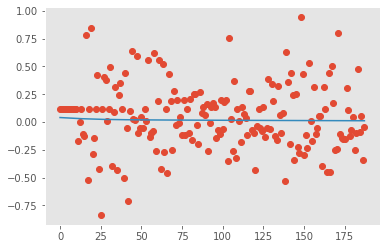

In [49]:
##
## Ejecución
##
tf.compat.v1.global_variables_initializer()
for i in range(max_iter):
  optimizer
p = ypred
e = SSE

print('SSE = ', e)
plt.plot(x, y, 'o')
plt.plot(Xpred, p, '-')
plt.grid()

In [50]:
translate_prediction(last_real_val_casos_col, ypred)

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([5793.1606], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([5967.2944], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6109.795], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6237.056], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6356.64], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6471.39], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6582.2886], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6689.655], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6793.595], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6894.1577], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6991.387], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([7085.34], dtype=float32)>,
 <tf.Tensor: shape=(1,), dt

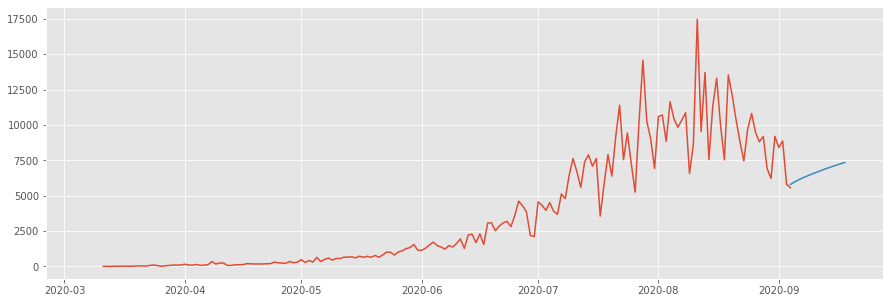

In [51]:
real_series = pd.Series(df_full['c_caso'].values, index=df_full['fecha'])
plt.figure(figsize=(15, 5))
plt.plot(real_series)

n_periods = 15
index_of_fc = pd.date_range(real_series.index[-1], periods = n_periods, freq='D')
fitted_series = pd.Series(translate_prediction(last_real_val_casos_col, ypred), index=index_of_fc)
plt.plot(fitted_series)

## SIR

In [52]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [53]:
# Funcion de maximizar (numero de infectados)
# N = poblacion total, beta = tasa de contacto y gamma = tasa de recuperación
def deriv(state, t, N, beta, gamma):
    S, I, R = state    
    dSdt = -beta * S * I / N    
    dIdt = beta * S * I / N - gamma * I    
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [54]:
df_full.c_caso.mean()

3635.5777777777776

In [55]:
df_full.c_recuperado.mean()

2863.7586206896553

In [56]:
df_full.c_fallecido.mean()

125.72619047619048

In [57]:
df_full['c_caso'].mean()

3635.5777777777776

R0 is 2.8000000000000003


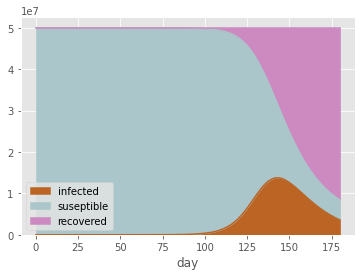

In [58]:
effective_contact_rate = 0.20 # beta
recovery_rate =  1/14 # gamma

print("R0 is", effective_contact_rate / recovery_rate)

# Condiciones iniciales para Colombia
total_pop = 50000000 # N
recovered = 0 
infected = 1
susceptible = total_pop - infected - recovered

# Dias, 0-181
days = range(0, 181)

ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, effective_contact_rate, recovery_rate))
S, I, R = ret.T

# Construccion del dataframe
df = pd.DataFrame({
    'suseptible': S.round(),
    'infected': I.round(),
    'recovered': R.round(),
    'day': days
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['infected', 'suseptible', 'recovered'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='area',
        stacked=True)

## Evaluacion de modelos

In [59]:
df

,suseptible,infected,recovered,day
0,49999999.0,1.0,0.0,0
1,49999999.0,1.0,0.0,1
2,49999999.0,1.0,0.0,2
3,49999998.0,1.0,0.0,3
4,49999998.0,2.0,0.0,4
...,...,...,...,...
176,5185447.0,4347287.0,40467266.0,176
177,5098270.0,4131700.0,40770030.0,177
178,5016789.0,3925480.0,41057732.0,178
179,4940593.0,3728377.0,41331030.0,179


In [60]:
df['infected_'] = df_full.c_caso
df['recovered_'] = df_full.c_recuperado

In [61]:
df

,suseptible,infected,recovered,day,infected_,recovered_
0,49999999.0,1.0,0.0,0,NaN,NaN
1,49999999.0,1.0,0.0,1,NaN,NaN
2,49999999.0,1.0,0.0,2,NaN,NaN
3,49999998.0,1.0,0.0,3,NaN,NaN
4,49999998.0,2.0,0.0,4,NaN,NaN
...,...,...,...,...,...,...
176,5185447.0,4347287.0,40467266.0,176,9725.0,10580.0
177,5098270.0,4131700.0,40770030.0,177,10812.0,11819.0
178,5016789.0,3925480.0,41057732.0,178,9491.0,11825.0
179,4940593.0,3728377.0,41331030.0,179,8812.0,10930.0


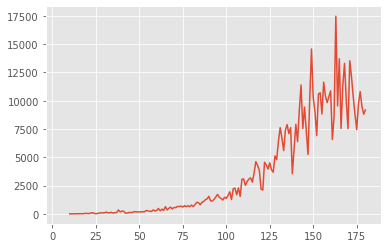

In [62]:
plt.plot(df['day'],df['infected_'])


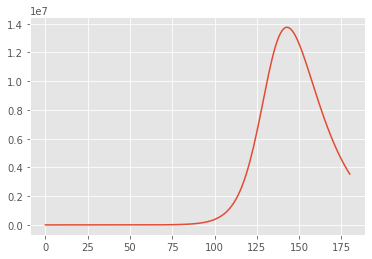

In [63]:
plt.plot(df['day'],df['infected'])

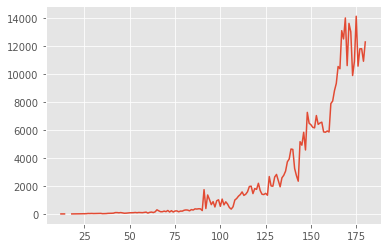

In [64]:
plt.plot(df['day'],df['recovered_'])

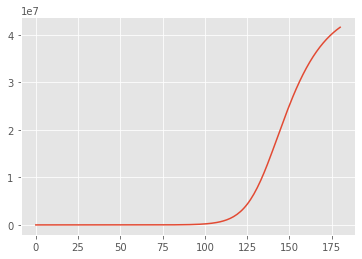

In [65]:
plt.plot(df['day'],df['recovered'])